# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


Обучениие производится на локальном компьютере. Поэтому распаковка zip произведена вручную. Не люблю Colab, потому  что ограничивает время. Что выразилось в покупке кмпьютера с RTX 3090 где я решаю что  делать и как.

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive/')

In [ ]:
#!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [ ]:
#!ls train

In [3]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sun Nov  5 14:50:10 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.01                 Driver Version: 546.01       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090      WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   44C    P8              35W / 350W |    942MiB / 24576MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

В нашем тесте будет 990 картинок, для которых вам будет необходимо предсказать класс.

In [4]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [5]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [6]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [7]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [8]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

In [9]:
# посмотрим на данные

result = {}
for name in [path.parent.name for path in sorted(list(TRAIN_DIR.rglob('*.jpg')))]:
    result[name] = result.get(name, 0) + 1
    
print(f'Всего изображений в классах: {sum(result.values())}') 
print(f'Размер минимального класса: {min(result.values())}')
print(f'Размер максимального класса: {max(result.values())}')
print(f'Количество классов: {len(result.values())}')

Количество классов: 42
Всего фотографий в классах: 20933
Размер минимального класса: 3
Размер максимального класса: 2246


Данных не много - всего 20933 изображений. Классы не сбалансированы. Разница в количестве данных до 748 раз. Будем добавлять данные.

In [10]:
# функция аугментации

from PIL import ImageEnhance
import random  

# функция аугментации

def augment_images(img, # -------------- изображение для аугментации
                   max_ang = 8, # ------ максимально возможный угол поворота
                   m_cx = 10, # -------- максимальное смещение центра по оси х
                   m_cy = 10, # -------- максимальное смещение центра по оси y
                   crop_w = 0.15, # ---- максимальная подрезка по ширине
                   crop_h = 0.15, # ---- максимальная подрезка по высоте
                   levcont = 0.5, # ---- параметр для коррекции контрастности
                   levbght = 0.5): # --- параметр для коррекции яркости

    def random_rote(x = img, max_ang = max_ang, m_cx = m_cx, m_cy = m_cy):
        global ang # делаем размер поворота доступным за функцией
        ang = np.random.randint(-max_ang, max_ang)  
        cx = np.random.randint(m_cx)
        cy = np.random.randint(m_cy)
        return  x.rotate(ang, center = (cx,cy))

    def random_crop(x = img, crop_w = crop_w, crop_h = crop_h):
        width, height = x.size # получаем размер входящей картинки

        # получаем случайные множители от до cut_w , cut_h соответственно
        kw = np.random.random()*crop_w
        kh = np.random.random()*crop_h 
        
        # вычисляем случайные значения left, upper, right, lower
        left = int(min(width*kw, width*0.2))
        upper = int(min(height*kh, height*0.2)) 
        right = np.random.randint(max(left, width*0.8), width)
        lower =  np.random.randint(max(upper,height*0.8), height)

        return x.crop((left, upper, right, lower))

    def trans_img(x = img):
        return x.transpose(Image.FLIP_LEFT_RIGHT)
    
    def random_contrast(x = img, levcont = levcont):
        enh = ImageEnhance.Contrast(x)
        factor = np.random.uniform(levcont, 2-levcont)
        return enh.enhance(factor)

    def random_bright(x = img, levbght = levbght):
        enh = ImageEnhance.Brightness(x)
        factor = np.random.uniform(levbght, 2-levbght)
        return enh.enhance(factor)
        
    # фунция, которая ничего не делает с изображением, оставляя как есть
    def img_img(x = img):
        return x
    
    # создаем список модификаций
    modificate = [random_rote, 
                  random_crop,
                  trans_img, 
                  random_contrast,
                  random_bright, 
                  img_img]

    # определяем количество модификаций из размера списка модификаций
    qty_mod = np.random.randint(1, len(modificate))

    # создаем список длины, равной кол-ву модификаций
    mod = list(range(len(modificate)))

    # перемешиваем
    np.random.shuffle(mod)

    # выбираем случайно индексы в количестве qty_mod
    lst_mod = random.sample(mod,qty_mod)

    # применяем модификации по индексам из lst_mod      
    for idx in lst_mod:  
        img = modificate[idx](img)

    # если был поворот - 0, то обрезаем края где черные углы о  поворота
    if 0 in lst_mod:
        # получаем ширину и высоту изображения
        width, height =  img.size       

        # высчитываем размер черного поля через угол, переведя в радианы
        crop_w = int(abs(height*np.sin(np.deg2rad(ang))))
        crop_h = int(abs(width*np.sin(np.deg2rad(ang))))

        # подрезаем картинку по краем, чтобы убрать черные поля от поворота
        img = img.crop((crop_w, crop_h, width-crop_w, height-crop_h))

    return img

In [ ]:
# добавляем данные в набор
for name, quantity in result.items():
    if quantity < max(result.values()) / 3: # определяем классы которые надо дополнить (критерий более чем в 3 раза меньше максимального)
        path = Path(f'./train/simpsons_dataset/{name}/').rglob('*.jpg')
        for filename in path:
            for i in range(int(max(result.values()) / quantity)):
                with Image.open(filename) as img:  # помещаем изображение в переменную
                    temp = augment_images(img) # аугментируем его
                    temp.save(f'{str(filename)[:-4]}_{i}.jpg')

In [45]:
# посмотрим на данные после аугментации
result = {}
for name in [path.parent.name for path in sorted(list(TRAIN_DIR.rglob('*.jpg')))]:
    result[name] = result.get(name, 0) + 1
    
print(f'Всего изображений в классах: {sum(result.values())}') 
print(f'Размер минимального класса: {min(result.values())}')
print(f'Размер максимального класса: {max(result.values())}')
print(f'Количество классов: {len(result.values())}')

Всего изображений в классах: 83739
Размер минимального класса: 877
Размер максимального класса: 2506
Количество классов: 42


После добавления классы имеют разброс в количестве данных в три раза. Увеличился исходный датасет до 83739 изображений, что должно положительно повлиять на обучение.

In [13]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
print(train_val_files)
print(test_files)

[WindowsPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0000.jpg'), WindowsPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0001.jpg'), WindowsPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0002.jpg'), WindowsPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0003.jpg'), WindowsPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0004.jpg'), WindowsPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0005.jpg'), WindowsPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0006.jpg'), WindowsPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0007.jpg'), WindowsPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0008.jpg'), WindowsPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0009.jpg'), WindowsPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0010.jpg'), WindowsPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0011.jpg'), WindowsPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0012.jpg'), WindowsPath('train/simps

In [14]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [15]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

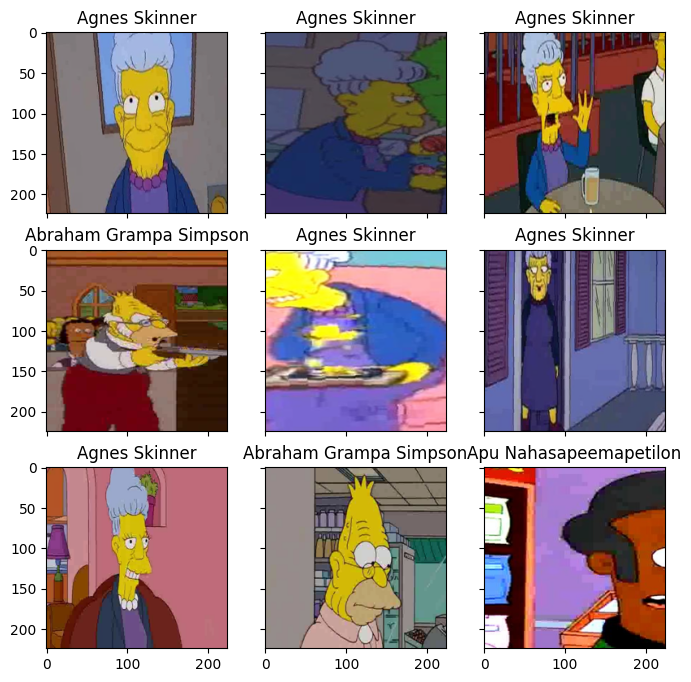

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [57]:
# Очень простая сеть

class SimpleCnn(nn.Module):    

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits
     

In [17]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [18]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [19]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [20]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Так как все изображения изначально были масштабированы к размеру 224x224 px и в классе SimpsonsDataset нормализации входа выполнена с параметрами - средние и дисперсии по каналам на основе ImageNet , да и в задании написано - "Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе)" попробуем это сделать.

Поэтому была взята стандартная resnet18 и обучена на увеличенном объёме данных (благо видеокарта моего локального компьютера это позволяет).

In [21]:
from torchvision.models import resnet18

n_classes = len(np.unique(train_val_labels))
simple_cnn =  resnet18(num_classes=n_classes).to(DEVICE) # SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): 

Запустим обучение сети.

In [22]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [23]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=50, batch_size=64)

epoch:   0%|          | 0/50 [00:00<?, ?it/s]

loss 1.3212460816100133


epoch:   2%|▏         | 1/50 [09:38<7:52:29, 578.56s/it]


Epoch 001 train_loss: 1.3212     val_loss 0.9942 train_acc 0.6461 val_acc 0.7308
loss 0.9089692558773642


epoch:   4%|▍         | 2/50 [15:29<5:55:40, 444.59s/it]


Epoch 002 train_loss: 0.9090     val_loss 0.4109 train_acc 0.7552 val_acc 0.8848
loss 0.25331359694838623


epoch:   6%|▌         | 3/50 [21:18<5:14:08, 401.04s/it]


Epoch 003 train_loss: 0.2533     val_loss 0.3092 train_acc 0.9295 val_acc 0.9130
loss 0.1759350700392293


epoch:   8%|▊         | 4/50 [27:10<4:52:41, 381.77s/it]


Epoch 004 train_loss: 0.1759     val_loss 0.2585 train_acc 0.9504 val_acc 0.9287
loss 0.12157275002079855


epoch:  10%|█         | 5/50 [33:01<4:37:49, 370.44s/it]


Epoch 005 train_loss: 0.1216     val_loss 0.1714 train_acc 0.9648 val_acc 0.9520
loss 0.10053723743578667


epoch:  12%|█▏        | 6/50 [38:51<4:26:31, 363.45s/it]


Epoch 006 train_loss: 0.1005     val_loss 0.1490 train_acc 0.9709 val_acc 0.9596
loss 0.08150330179745047


epoch:  14%|█▍        | 7/50 [44:44<4:18:05, 360.12s/it]


Epoch 007 train_loss: 0.0815     val_loss 0.1834 train_acc 0.9765 val_acc 0.9520
loss 0.06584708616639319


epoch:  16%|█▌        | 8/50 [50:37<4:10:29, 357.86s/it]


Epoch 008 train_loss: 0.0658     val_loss 0.1153 train_acc 0.9808 val_acc 0.9703
loss 0.052017625065830006


epoch:  18%|█▊        | 9/50 [56:29<4:03:15, 355.98s/it]


Epoch 009 train_loss: 0.0520     val_loss 0.1426 train_acc 0.9849 val_acc 0.9637
loss 0.04380175617480072


epoch:  20%|██        | 10/50 [1:02:22<3:56:45, 355.14s/it]


Epoch 010 train_loss: 0.0438     val_loss 0.1443 train_acc 0.9872 val_acc 0.9692
loss 0.04355580916990559


epoch:  22%|██▏       | 11/50 [1:08:13<3:50:04, 353.95s/it]


Epoch 011 train_loss: 0.0436     val_loss 0.1393 train_acc 0.9874 val_acc 0.9664
loss 0.037754433990713925


epoch:  24%|██▍       | 12/50 [1:14:06<3:43:53, 353.52s/it]


Epoch 012 train_loss: 0.0378     val_loss 0.1381 train_acc 0.9887 val_acc 0.9676
loss 0.02971993518969381


epoch:  26%|██▌       | 13/50 [1:20:00<3:38:11, 353.84s/it]


Epoch 013 train_loss: 0.0297     val_loss 0.1348 train_acc 0.9916 val_acc 0.9729
loss 0.03218204656098036


epoch:  28%|██▊       | 14/50 [1:25:51<3:31:48, 353.03s/it]


Epoch 014 train_loss: 0.0322     val_loss 0.1262 train_acc 0.9908 val_acc 0.9724
loss 0.0273297203083914


epoch:  30%|███       | 15/50 [1:31:42<3:25:27, 352.20s/it]


Epoch 015 train_loss: 0.0273     val_loss 0.1196 train_acc 0.9923 val_acc 0.9738
loss 0.020060445035118783


epoch:  32%|███▏      | 16/50 [1:37:32<3:19:17, 351.68s/it]


Epoch 016 train_loss: 0.0201     val_loss 0.1627 train_acc 0.9945 val_acc 0.9641
loss 0.027121178702653244


epoch:  34%|███▍      | 17/50 [1:43:20<3:12:51, 350.65s/it]


Epoch 017 train_loss: 0.0271     val_loss 0.1627 train_acc 0.9925 val_acc 0.9603
loss 0.020872891511913603


epoch:  36%|███▌      | 18/50 [1:49:10<3:06:53, 350.41s/it]


Epoch 018 train_loss: 0.0209     val_loss 0.1088 train_acc 0.9939 val_acc 0.9778
loss 0.018333298056632454


epoch:  38%|███▊      | 19/50 [1:54:59<3:00:49, 349.98s/it]


Epoch 019 train_loss: 0.0183     val_loss 0.1115 train_acc 0.9950 val_acc 0.9764
loss 0.01978778480275937


epoch:  40%|████      | 20/50 [2:00:48<2:54:48, 349.61s/it]


Epoch 020 train_loss: 0.0198     val_loss 0.1246 train_acc 0.9945 val_acc 0.9724
loss 0.020827188919923842


epoch:  42%|████▏     | 21/50 [2:06:39<2:49:11, 350.04s/it]


Epoch 021 train_loss: 0.0208     val_loss 0.1641 train_acc 0.9943 val_acc 0.9689
loss 0.017514355373772602


epoch:  44%|████▍     | 22/50 [2:12:28<2:43:10, 349.65s/it]


Epoch 022 train_loss: 0.0175     val_loss 0.1798 train_acc 0.9952 val_acc 0.9632
loss 0.017132300509957767


epoch:  46%|████▌     | 23/50 [2:18:16<2:37:07, 349.15s/it]


Epoch 023 train_loss: 0.0171     val_loss 0.1274 train_acc 0.9953 val_acc 0.9757
loss 0.014760936141657615


epoch:  48%|████▊     | 24/50 [2:24:07<2:31:30, 349.63s/it]


Epoch 024 train_loss: 0.0148     val_loss 0.1076 train_acc 0.9962 val_acc 0.9789
loss 0.0159132479090783


epoch:  50%|█████     | 25/50 [2:29:56<2:25:38, 349.53s/it]


Epoch 025 train_loss: 0.0159     val_loss 0.1058 train_acc 0.9957 val_acc 0.9795
loss 0.012072606716033695


epoch:  52%|█████▏    | 26/50 [2:35:43<2:19:30, 348.76s/it]


Epoch 026 train_loss: 0.0121     val_loss 0.1061 train_acc 0.9964 val_acc 0.9817
loss 0.021156524133562036


epoch:  54%|█████▍    | 27/50 [2:41:36<2:14:11, 350.07s/it]


Epoch 027 train_loss: 0.0212     val_loss 0.1064 train_acc 0.9945 val_acc 0.9767
loss 0.012063961335452499


epoch:  56%|█████▌    | 28/50 [2:47:31<2:08:55, 351.60s/it]


Epoch 028 train_loss: 0.0121     val_loss 0.1245 train_acc 0.9966 val_acc 0.9741
loss 0.014922792525878003


epoch:  58%|█████▊    | 29/50 [2:53:31<2:03:55, 354.06s/it]


Epoch 029 train_loss: 0.0149     val_loss 0.1102 train_acc 0.9961 val_acc 0.9797
loss 0.009507029203185396


epoch:  60%|██████    | 30/50 [2:59:32<1:58:41, 356.05s/it]


Epoch 030 train_loss: 0.0095     val_loss 0.1172 train_acc 0.9975 val_acc 0.9770
loss 0.016915578990385524


epoch:  62%|██████▏   | 31/50 [3:05:31<1:53:04, 357.10s/it]


Epoch 031 train_loss: 0.0169     val_loss 0.1405 train_acc 0.9961 val_acc 0.9760
loss 0.014627035304825507


epoch:  64%|██████▍   | 32/50 [3:11:24<1:46:47, 355.98s/it]


Epoch 032 train_loss: 0.0146     val_loss 0.1182 train_acc 0.9961 val_acc 0.9786
loss 0.01053021997879311


epoch:  66%|██████▌   | 33/50 [3:17:11<1:40:01, 353.05s/it]


Epoch 033 train_loss: 0.0105     val_loss 0.1392 train_acc 0.9972 val_acc 0.9725
loss 0.01275017905308007


epoch:  68%|██████▊   | 34/50 [3:22:59<1:33:46, 351.63s/it]


Epoch 034 train_loss: 0.0128     val_loss 0.1537 train_acc 0.9969 val_acc 0.9722
loss 0.009781248102266717


epoch:  70%|███████   | 35/50 [3:28:46<1:27:33, 350.24s/it]


Epoch 035 train_loss: 0.0098     val_loss 0.1228 train_acc 0.9976 val_acc 0.9777
loss 0.013188693171008565


epoch:  72%|███████▏  | 36/50 [3:34:32<1:21:24, 348.90s/it]


Epoch 036 train_loss: 0.0132     val_loss 0.1724 train_acc 0.9970 val_acc 0.9671
loss 0.013543168373440452


epoch:  74%|███████▍  | 37/50 [3:40:19<1:15:30, 348.51s/it]


Epoch 037 train_loss: 0.0135     val_loss 0.1348 train_acc 0.9965 val_acc 0.9756
loss 0.008824042207247959


epoch:  76%|███████▌  | 38/50 [3:46:08<1:09:41, 348.47s/it]


Epoch 038 train_loss: 0.0088     val_loss 0.1269 train_acc 0.9979 val_acc 0.9783
loss 0.011310364969649964


epoch:  78%|███████▊  | 39/50 [3:51:53<1:03:41, 347.41s/it]


Epoch 039 train_loss: 0.0113     val_loss 0.1205 train_acc 0.9971 val_acc 0.9786
loss 0.012761023834714419


epoch:  80%|████████  | 40/50 [3:57:41<57:55, 347.58s/it]  


Epoch 040 train_loss: 0.0128     val_loss 0.1691 train_acc 0.9967 val_acc 0.9647
loss 0.005020005898996691


epoch:  82%|████████▏ | 41/50 [4:03:29<52:09, 347.67s/it]


Epoch 041 train_loss: 0.0050     val_loss 0.1252 train_acc 0.9987 val_acc 0.9801
loss 0.011237226814083972


epoch:  84%|████████▍ | 42/50 [4:09:15<46:19, 347.41s/it]


Epoch 042 train_loss: 0.0112     val_loss 0.1763 train_acc 0.9971 val_acc 0.9712
loss 0.013751647327078965


epoch:  86%|████████▌ | 43/50 [4:15:04<40:35, 347.87s/it]


Epoch 043 train_loss: 0.0138     val_loss 0.1525 train_acc 0.9966 val_acc 0.9733
loss 0.010355109936559281


epoch:  88%|████████▊ | 44/50 [4:20:52<34:46, 347.72s/it]


Epoch 044 train_loss: 0.0104     val_loss 0.1296 train_acc 0.9974 val_acc 0.9780
loss 0.008500090858429059


epoch:  90%|█████████ | 45/50 [4:26:39<28:57, 347.56s/it]


Epoch 045 train_loss: 0.0085     val_loss 0.0969 train_acc 0.9979 val_acc 0.9836
loss 0.008724256586988348


epoch:  92%|█████████▏| 46/50 [4:32:28<23:11, 347.94s/it]


Epoch 046 train_loss: 0.0087     val_loss 0.1603 train_acc 0.9979 val_acc 0.9732
loss 0.010066767698166269


epoch:  94%|█████████▍| 47/50 [4:38:15<17:22, 347.64s/it]


Epoch 047 train_loss: 0.0101     val_loss 0.1263 train_acc 0.9975 val_acc 0.9804
loss 0.008394462434191554


epoch:  96%|█████████▌| 48/50 [4:44:01<11:34, 347.40s/it]


Epoch 048 train_loss: 0.0084     val_loss 0.1222 train_acc 0.9978 val_acc 0.9770
loss 0.011012012687278687


epoch:  98%|█████████▊| 49/50 [4:49:50<05:47, 347.71s/it]


Epoch 049 train_loss: 0.0110     val_loss 0.1649 train_acc 0.9972 val_acc 0.9671
loss 0.0107793296132859


epoch: 100%|██████████| 50/50 [4:55:36<00:00, 354.72s/it]


Epoch 050 train_loss: 0.0108     val_loss 0.1052 train_acc 0.9973 val_acc 0.9793


Построим кривые обучения

In [26]:
loss, acc, val_loss, val_acc = zip(*history)

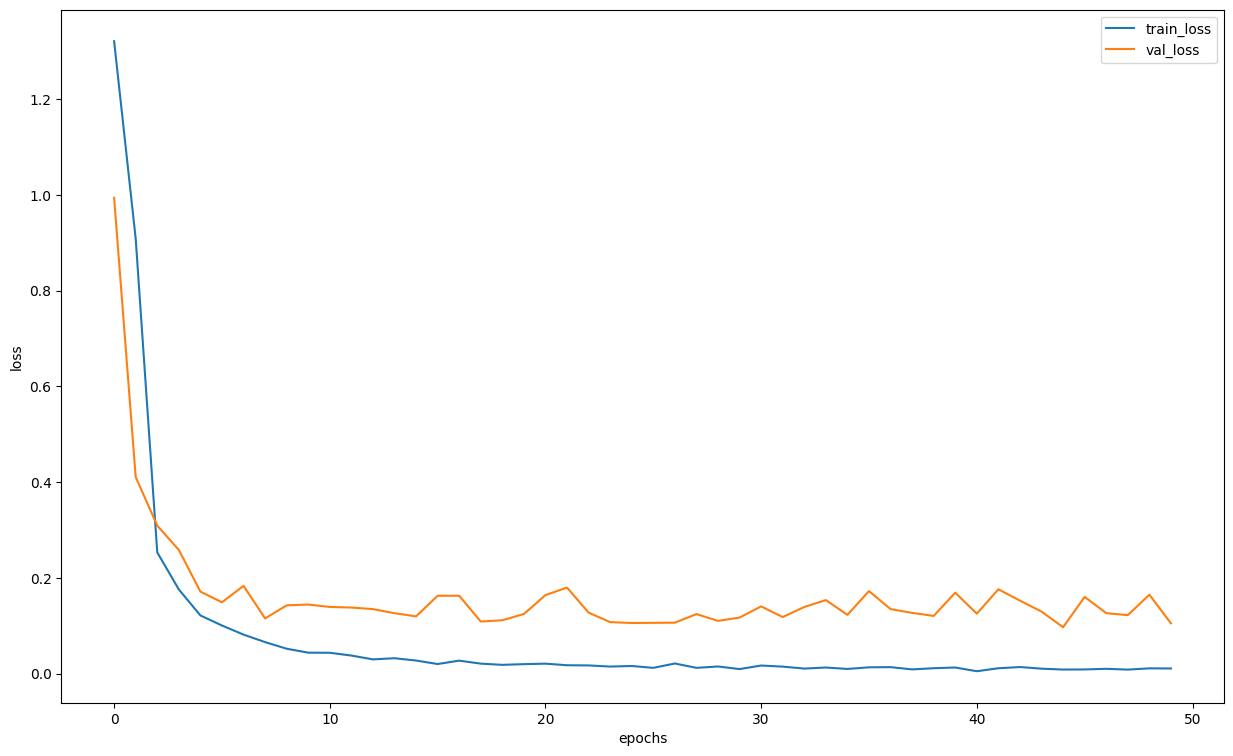

In [27]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [30]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [31]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [32]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [33]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [34]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [35]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 0.9


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете использовать это, чтобы отлаживать правильность вывода.

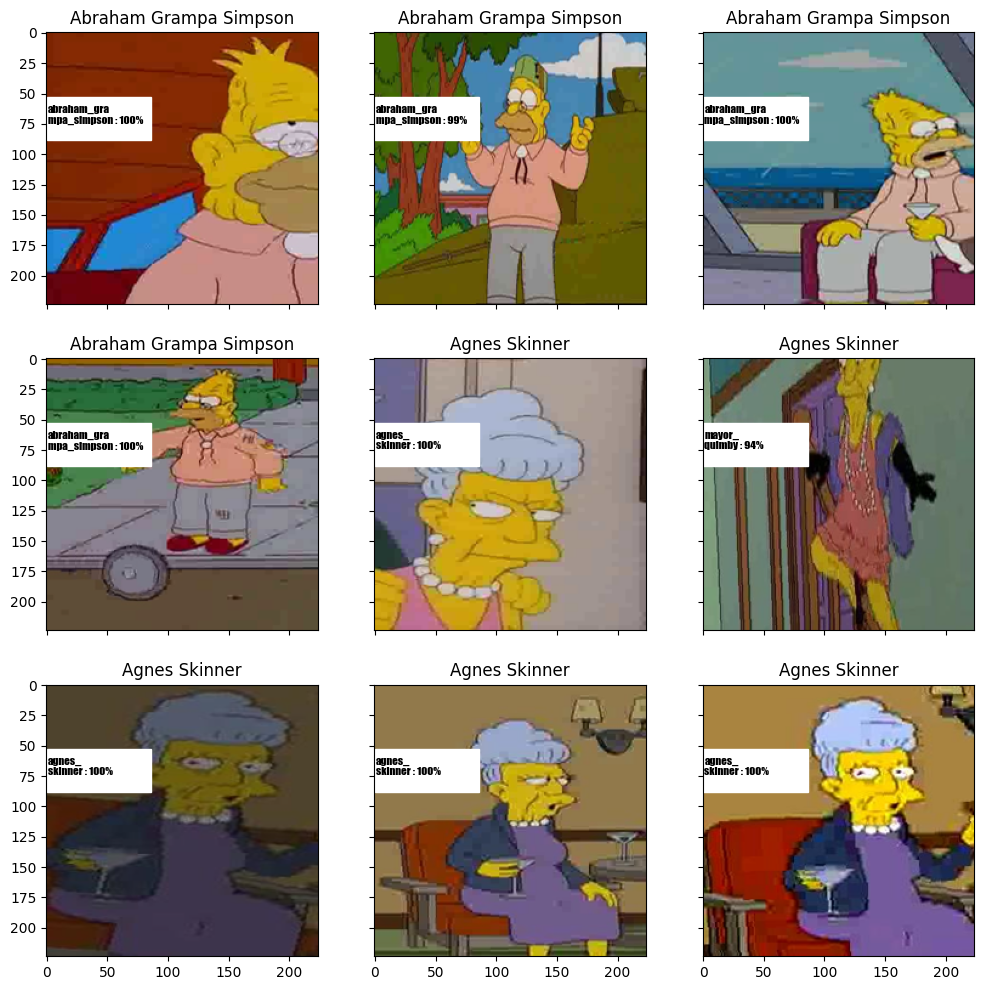

In [36]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [37]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
#! ls

In [49]:
import pandas as pd
#my_submit = pd.read_csv("sample_submission.csv")  # "/content/sample_submission.csv"
my_submit = pd.DataFrame({'id': test_filenames, 'Expected': preds})
my_submit.head()

id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon

In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [50]:
my_submit.to_csv('simple_cnn_baseline.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


Для первого раза получилоось неплохо. Чтобы улучшить результат - сделал бы выбор лучшей модели по результатам обучения и прекратил бы обучение, если бы результат существенно не менялся (в моем случае достаточно 20 эпох). Но так как результат на Caggle достаточен для получения наивысшего балла - 0.98618 оставим это на другой раз.

In [ ]:
# 1369 Александр_Андреев_400762454 0.98618 1 4m